<a href="https://colab.research.google.com/github/jhermosillo/DIPLOMADO_CDP/blob/main/Modulo%205%20-%20Deep%20Leaning/code/DL_06_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Part 1: Download data and set directories

In [ ]:
# Download data
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 0s 0us/step


In [ ]:
# Define paths to training and validation images
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')

# Specify them by class
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with training dog pictures
val_cats_dir = os.path.join(val_dir, 'cats')      # directory with validation cat pictures
val_dogs_dir = os.path.join(val_dir, 'dogs')      # directory with validation dog pictures

In [ ]:
# Count how many of them are there
n_cats_train = len(os.listdir(train_cats_dir))
n_dogs_train = len(os.listdir(train_dogs_dir))

n_cats_val = len(os.listdir(val_cats_dir))
n_dogs_val = len(os.listdir(val_dogs_dir))

n_total_train = n_cats_train + n_dogs_train
n_total_val = n_cats_val + n_dogs_val

# Print some info
print('total training cat images:', n_cats_train)
print('total training dog images:', n_dogs_train)

print('total validation cat images:', n_cats_val)
print('total validation dog images:', n_dogs_val)
print("--")
print("Total training images:", n_total_train)
print("Total validation images:", n_total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Part 2: Define batch-generator process

In [ ]:
# Define some constants
batch_size = 16
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [ ]:
# Define generator objects for training and validation data
train_generator = ImageDataGenerator(rescale=1./255)
val_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
# Define method to load images from disk, apply rescaling, and resize them into specified size.
train_gen = train_generator.flow_from_directory(batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')
val_gen = val_generator.flow_from_directory(batch_size=batch_size,
                                            directory=val_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Part 3: Import pretrained model and fine tune it

In [ ]:
# Import VGGnet pretrained on the ImageNet dataset
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
vgg_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
vgg_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

Weights: (3, 3, 128, 128)
bias: (128,)


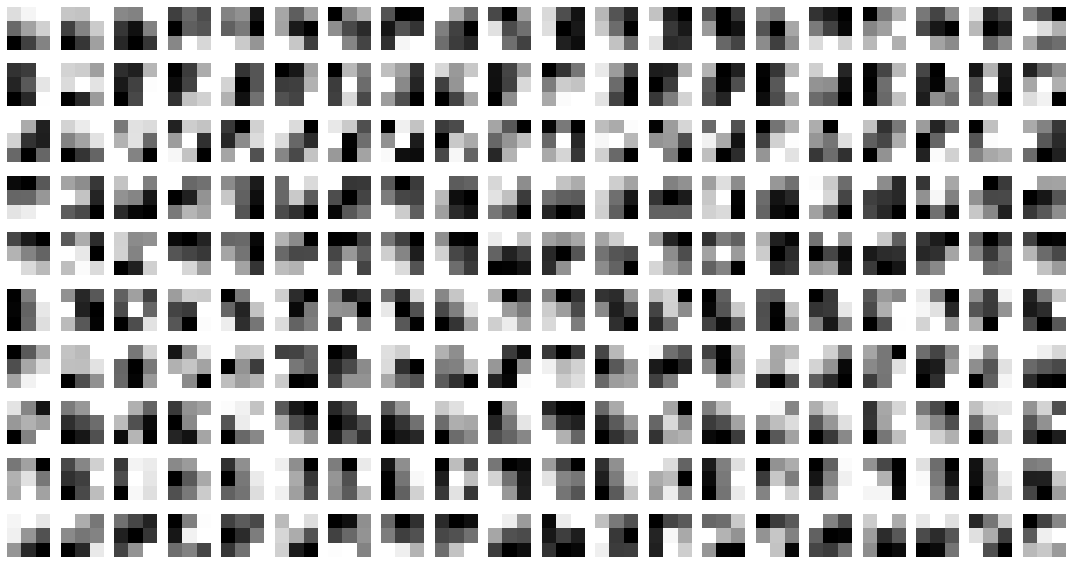

In [ ]:
# Get all kernels from the 5-th hidden layer of the vggnet
W, b = vgg_model.layers[5].get_weights()
print("Weights:", W.shape)
print("bias:", b.shape)

# Visualize a few examples
ind_plot = 1
plt.figure(figsize=(15, 8))
for ind_filter in range(10):
  for ind_chann in range(20):
    img = W[:, :, ind_chann, ind_filter].copy() + b[ind_filter]
    img -= img.min()
    img /= img.max()
    plt.subplot(10, 20, ind_plot)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    ind_plot += 1
plt.tight_layout()
plt.show()

In [ ]:
# Freeze all pre-trained kernels
vgg_model.trainable = False

In [ ]:
#
model = tf.keras.Sequential([
  vgg_model,
  #tf.keras.layers.Conv2D(128, 3, activation='relu'),
  #tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 128)         589952    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 15,321,281
Trainable params: 606,593
Non-trainable params: 14,714,688
______________________________________

In [ ]:
# Compile it
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Train model
n_epochs = 16
history = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=n_total_train//batch_size,
    epochs=n_epochs,
    validation_data=val_gen,
    validation_steps=n_total_val//batch_size
)

Epoch 1/16
125/125 [==============================] - 15s 122ms/step - loss: 0.6202 - acc: 0.7400 - val_loss: 0.5885 - val_acc: 0.8276
Epoch 2/16
125/125 [==============================] - 8s 67ms/step - loss: 0.5730 - acc: 0.8520 - val_loss: 0.5834 - val_acc: 0.8498
Epoch 3/16
125/125 [==============================] - 8s 65ms/step - loss: 0.5594 - acc: 0.8835 - val_loss: 0.5777 - val_acc: 0.8125
Epoch 4/16
125/125 [==============================] - 8s 65ms/step - loss: 0.5488 - acc: 0.9095 - val_loss: 0.5701 - val_acc: 0.8558
Epoch 5/16
125/125 [==============================] - 8s 66ms/step - loss: 0.5407 - acc: 0.9265 - val_loss: 0.5739 - val_acc: 0.8679
Epoch 6/16
125/125 [==============================] - 8s 66ms/step - loss: 0.5350 - acc: 0.9435 - val_loss: 0.5693 - val_acc: 0.8659
Epoch 7/16
125/125 [==============================] - 8s 65ms/step - loss: 0.5302 - acc: 0.9500 - val_loss: 0.5681 - val_acc: 0.8478
Epoch 8/16
125/125 [==============================] - 8s 64ms/step 

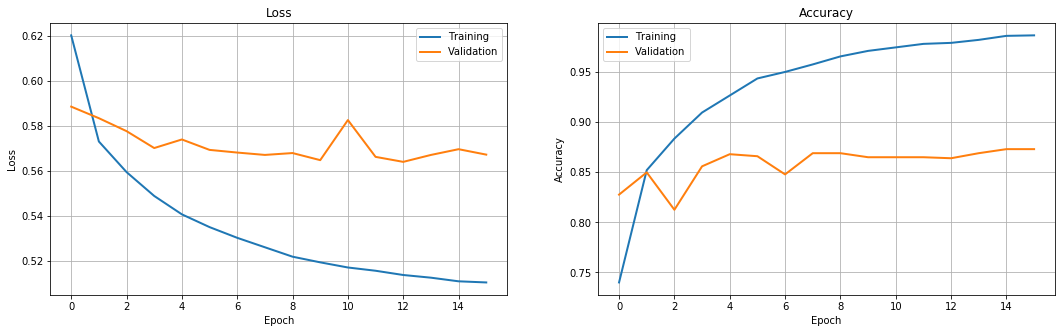

In [ ]:
# Plot loss
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='Training', linewidth=2)
plt.plot(history.history['val_acc'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

# Part 4: Visualize intermediate feature maps (signal response)

In [ ]:
# Now create a sub-model, from vgg, from input to 5th layer
from tensorflow.keras.models import Model
model2 = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[5].output)
model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
Total params: 260,160
Trainable params: 0
Non-trainable params: 260,160
_____________________________________________________

(16, 128, 128, 3)


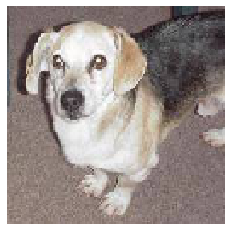

In [ ]:
# Generate a random batch, use first sample
sample_x, sample_y = next(train_gen)
print(sample_x.shape)

# Plot first sample
plt.imshow(sample_x[0])
plt.axis('off')
plt.show()

(16, 64, 64, 128)


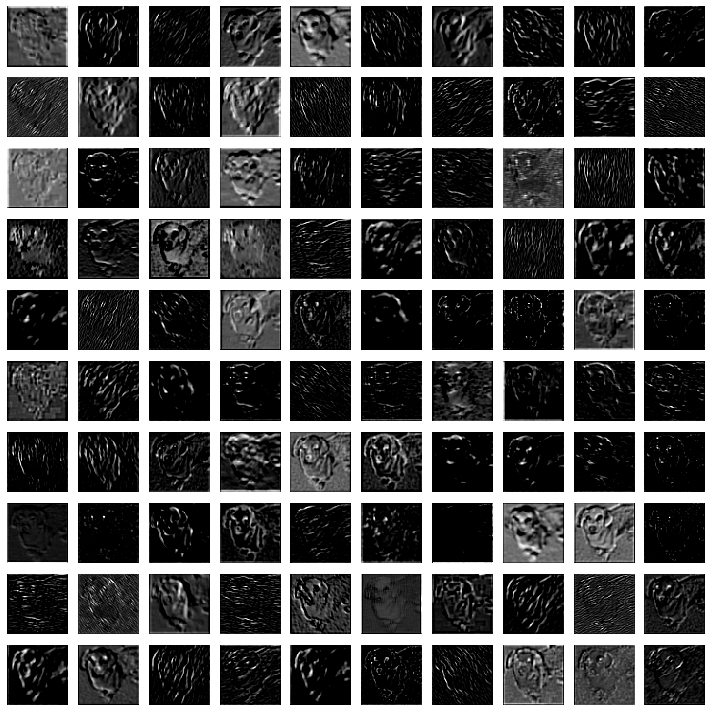

In [ ]:
# Predict
feat_map = model2.predict(sample_x)
print(feat_map.shape)

# Show a few feature maps (kernel responses)
a_sample = feat_map[0]
plt.figure(figsize=(10, 10))
for ind in range(100):
  img = a_sample[:, :, ind].copy()
  img -= img.min()
  img /= img.max()
  plt.subplot(10, 10, ind+1)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# == Q ==
# 1. Investiga de qué manera se almacenan las capas (layers) de los modelos de tf.keras.
# 2. ¿Cómo imprimirías información sobre el número de capas que tiene un modelo?
# 3. Para el caso particular de transferencia de conocimiento, en el cual usas un modelo preentrenado
#    como segmento de un modelo más grande, ¿cambia la forma en que se almacenan las capas?
# 4. Explica el procedimiento para visualizar los kernels entrenados de alguna capa intermedia
#    (puedes ayudarte de líneas de código, pero la importancia de esta pregunta radica en que
#    puedas explicar qué hace cada línea de código).
# 5. De maner similar, explica el procedimiento para visualizar las salidas de las capas 
#    intermedias (feature map o image response).

# Data Augmentation

In [ ]:
# Definimos un nuevo tipo de generador, con parametros de aumentación
image_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=45,
                                     width_shift_range=0.15,
                                     height_shift_range=.15,
                                     zoom_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True
                                    )

# Creamos un generador con parametros iguales a los definidos en el ejercicio anterior
img_gen = image_generator.flow_from_directory(batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')

Found 2000 images belonging to 2 classes.


(16, 128, 128, 3)
0.0
1.0
(16,)
[0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.]


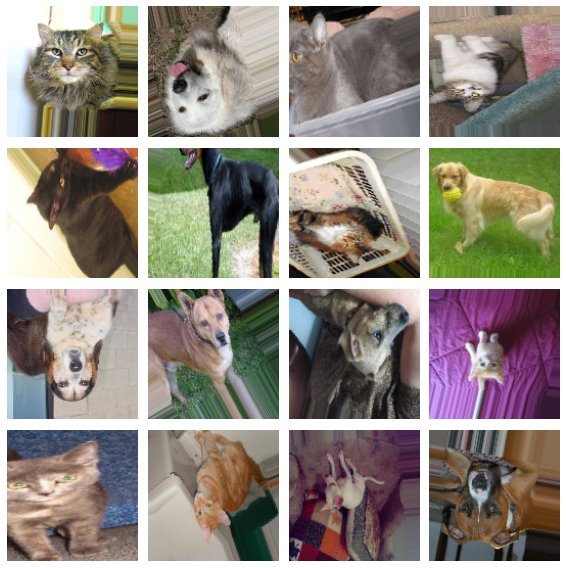

In [ ]:
# Muestra los ejemplos
sample_x, sample_y = next(img_gen)
print(sample_x.shape)
print(sample_x.min())
print(sample_x.max())
print(sample_y.shape)
print(sample_y[:20])

# Show a few of them
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()
for img, ax in zip(sample_x, axes):
  ax.imshow(img)
  ax.axis('off')
plt.tight_layout()
plt.show()

# Extra: save and load model

In [ ]:
# Saving
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model # now delet it from memory

In [ ]:
# Restoring a saved model
from tensorflow.keras.models import load_model
model = load_model('my_model.h5')
# More optinos in: https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model